Установка зависимостей

In [19]:
%pip install numpy==1.26.2 scikit-learn==1.3.2 matplotlib==3.8.2 six==1.16.0 tensorflow==2.15.0
%pip install machine-learning-datasets==0.1.23
%pip install rulefit==0.3.1
%pip install statsmodels==0.14.0
%pip install tqdm==4.66.1
%pip install --no-deps cvae==0.0.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Загрузка данных

In [2]:
import machine_learning_datasets as mldatasets

df = mldatasets.load("aa-domestic-delays-2018")
df.info()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /Users/user/Projects/python/ai/3/data/aa-domestic-delays-2018.csv.zip
/Users/user/Projects/python/ai/3/data/aa-domestic-delays-2018.csv.zip uncompressed to /Users/user/Projects/python/ai/3/data/aa-domestic-delays-2018.csv
1 dataset files found in /Users/user/Projects/python/ai/3/data/aa-domestic-delays-2018.csv folder
parsing /Users/user/Projects/python/ai/3/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DE

Подготовка данных

In [3]:
import pandas as pd

# Преобразование даты из строки в datetime
df["PLANNED_DEP_DATETIME"] = pd.to_datetime(df["PLANNED_DEP_DATETIME"])
# Получение месяца и дня недели вылета из даты для учета сезонности и особенностей дня недели
df["DEP_MONTH"] = df["PLANNED_DEP_DATETIME"].dt.month
df["DEP_DOW"] = df["PLANNED_DEP_DATETIME"].dt.dayofweek
# Удаление столбца с датой
df = df.drop(["PLANNED_DEP_DATETIME"], axis=1)
# Список аэропортов-хабов
hubs = ["CLT", "ORD", "DFW", "LAX", "MIA", "JFK", "LGA", "PHL", "PHX", "DCA"]
# Определение признака хаба для аэропортов вылета и назначения
is_origin_hub = df["ORIGIN"].isin(hubs)
is_dest_hub = df["DEST"].isin(hubs)
# Установка признака хаба для данных
df["ORIGIN_HUB"] = 0
df.loc[is_origin_hub, "ORIGIN_HUB"] = 1
df["DEST_HUB"] = 0
df.loc[is_dest_hub, "DEST_HUB"] = 1
# Удаление лишних столбцов
df = df.drop(["FL_NUM", "ORIGIN", "DEST"], axis=1)
# Удаление столбца с общим временем задержки прибытия, так как данные значения будут иметь сильное влияние на результат
df = df.drop(["ARR_DELAY"], axis=1)

Формирование тестовой и обучающей выборок данных

In [4]:
from sklearn.model_selection import train_test_split

# Задание фиксированного случайного состояния для воспроизводимости результатов
rand = 9
# Выделение признака, который модель должна предсказать
y = df["CARRIER_DELAY"]
# Формирование множества признаков, на основе которых модель будет обучаться (удаление столбца с y)
X = df.drop(["CARRIER_DELAY"], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.15, random_state=rand
)
# Создание классов для классификаторов в виде двоичных меток (опоздание свыше 15 минут - 1, иначе - 0)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

Определение линейной корреляции признаков с целевым признаком с помощью корреляции Пирсона

In [5]:
corr = df.corr()
abs(corr["CARRIER_DELAY"]).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

Использование регрессионных моделей для предсказания задержки рейса

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import linear_model, tree, neighbors, ensemble, neural_network
from rulefit import RuleFit

reg_models = {
    # Обобщенные линейные модели (GLM-модели)
    "linear": {"model": linear_model.LinearRegression(n_jobs=-1)},
    "linear_poly": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "linear_interact": {
        "model": make_pipeline(
            PolynomialFeatures(interaction_only=True),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "ridge": {"model": linear_model.RidgeCV()},  # alphas=(1e-3, 1e-2, 1e-1, 1.0)
    # Деревья
    "decision_tree": {
        "model": tree.DecisionTreeRegressor(max_depth=7, random_state=rand)
    },
    # RuleFit
    "rulefit": {"model": RuleFit(max_rules=150, rfmode="regress", random_state=rand)},
    # Ближайшие соседи
    "knn": {"model": neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)},
    # Ансамблевые методы
    "random_forest": {
        "model": ensemble.RandomForestRegressor(
            max_depth=7, random_state=rand, n_jobs=-1
        )
    },
    # Нейронные сети
    "mlp": {
        "model": neural_network.MLPRegressor(
            hidden_layer_sizes=(21,),
            max_iter=500,
            early_stopping=True,
            random_state=rand,
        )
    },
}

Обучение и оценка регрессионных моделей



In [ ]:
import math
from sklearn import metrics

for model_name in reg_models.keys():
    print(f'Model: {model_name}')
    if model_name != "rulefit":
        fitted_model = reg_models[model_name]["model"].fit(X_train, y_train_reg)
    else:
        fitted_model = reg_models[model_name]["model"].fit(
            X_train.values, y_train_reg.values, X_test.columns
        )
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]["fitted"] = fitted_model
    reg_models[model_name]["preds"] = y_test_pred
    reg_models[model_name]["RMSE_train"] = math.sqrt(
        metrics.mean_squared_error(y_train_reg, y_train_pred)
    )
    reg_models[model_name]["RMSE_test"] = math.sqrt(
        metrics.mean_squared_error(y_test_reg, y_test_pred)
    )
    reg_models[model_name]["R2_test"] = metrics.r2_score(y_test_reg, y_test_pred)

Вывод оценки в виде таблицы

In [11]:
reg_metrics = pd.DataFrame.from_dict(reg_models, "index")[
    ["RMSE_train", "RMSE_test", "R2_test"]
]
reg_metrics.sort_values(by="RMSE_test").style.background_gradient(
    cmap="viridis", low=1, high=0.3, subset=["RMSE_train", "RMSE_test"]
).background_gradient(cmap="plasma", low=0.3, high=1, subset=["R2_test"])

,RMSE_train,RMSE_test,R2_test
mlp,3.243516,3.308597,0.987025
random_forest,5.143267,6.088249,0.956065
linear_poly,6.213987,6.339854,0.952359
linear_interact,6.454305,6.562285,0.948957
decision_tree,6.542924,7.456335,0.934102
linear,7.819643,7.882875,0.926347
ridge,7.868031,7.936255,0.925346
knn,7.360098,9.259422,0.898377
rulefit,9.171515,9.308936,0.897287


Использование классификаторов для предсказания задержки рейса

In [13]:
from sklearn import naive_bayes

class_models = {
    # Обобщенные линейные модели (GLM-модели)
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {
        "model": linear_model.RidgeClassifierCV(
            cv=5, class_weight="balanced"
        )
    },
    # Дерево
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=rand)
    },
    # Ближайшие соседи
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    # Наивный Байес
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    # Ансамблевые методы
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=rand
        )
    },
    # Нейронные сети
    "mlp": {
        "model": make_pipeline(
            StandardScaler(),
            neural_network.MLPClassifier(
                hidden_layer_sizes=(7,),
                max_iter=500,
                early_stopping=True,
                random_state=rand,
            ),
        )
    },
}

Определение сбалансированности выборки для классификации

In [ ]:
y_train_class[y_train_class == 1].shape[0] / y_train_class.shape[0]

Обучение и оценка классификаторов

In [ ]:
import numpy as np

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    fitted_model = class_models[model_name]["model"].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_prob = []
    if model_name == "ridge":
        y_test_pred = fitted_model.predict(X_test.values)
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:, 1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]["fitted"] = fitted_model
    class_models[model_name]["probs"] = y_test_prob
    class_models[model_name]["preds"] = y_test_pred
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train_class, y_train_pred
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test_class, y_test_pred
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train_class, y_train_pred
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test_class, y_test_pred
    )
    if model_name != "ridge":
        class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
            y_test_class, y_test_prob
        )
    else:
        class_models[model_name]["ROC_AUC_test"] = 0
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test_class, y_test_pred
    )

Вывод оценки в виде таблицы

In [16]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_train",
        "Accuracy_test",
        "Recall_train",
        "Recall_test",
        "ROC_AUC_test",
        "F1_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma", low=0.3, high=1, subset=["Accuracy_train", "Accuracy_test"]
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=["Recall_train", "Recall_test", "ROC_AUC_test", "F1_test", "MCC_test"],
)

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998482,0.998555,0.987131,0.988865,0.999877,0.988207,0.987437
gradient_boosting,0.991725,0.991662,0.892930,0.893851,0.998885,0.929223,0.925619
random_forest,0.941040,0.940221,0.999573,0.992254,0.995186,0.670264,0.685317
decision_tree,0.983297,0.982895,0.856969,0.852215,0.994932,0.859182,0.850110
logistic,0.974851,0.974950,0.684081,0.683370,0.961908,0.769629,0.763426
knn,0.972886,0.965123,0.680645,0.607722,0.948387,0.680906,0.668176
naive_bayes,0.925119,0.925539,0.279126,0.274268,0.811869,0.310858,0.274984
ridge,0.890512,0.891247,0.776874,0.778383,0.000000,0.467098,0.463863


Методы сжатия размерности

In [ ]:
from sklearn import decomposition, manifold
import sys
from tensorflow._api.v2.compat import v1 as tf

sys.modules["tensorflow"] = tf
from cvae import cvae

X_train_abbrev = X_train.iloc[:, [0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.iloc[:, [0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(
    X_test.shape[0], math.ceil(X_test.shape[0] * sample_size), replace=False
)

dimred_methods = {
    # Разложение
    "pca": {"method": decomposition.PCA(n_components=3, random_state=rand)},
    # Усвоение проекций в топологическом многообразии
    "t-sne": {"method": manifold.TSNE(n_components=3, random_state=rand)},
    # Вариационные автокодировщики
    "vae": {
        "method": cvae.CompressionVAE(
            X_train_abbrev.values, dim_latent=3, tb_logging=False
        )
    },
}

Выполнение сжатия размерности

In [ ]:
for method_name in dimred_methods.keys():
    if method_name != "vae":
        lowdim_data = dimred_methods[method_name]["method"].fit_transform(
            X_test_abbrev.values[sample_idx]
        )
    else:
        fitted_model = dimred_methods[method_name]["method"].train(num_steps=1000)
        lowdim_data = fitted_model.embed(X_test_abbrev.values[sample_idx])
        dimred_methods[method_name]["fitted"] = fitted_model
    dimred_methods[method_name]["lowdim"] = lowdim_data

# Легенда
y_names = {0: "Not Delayed", 1: "Delayed"}

Визуализация результатов на основе PCA

/var/folders/rg/tppcrnhx45335twpt226wpf00000gn/T/ipykernel_43329/2100592153.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(


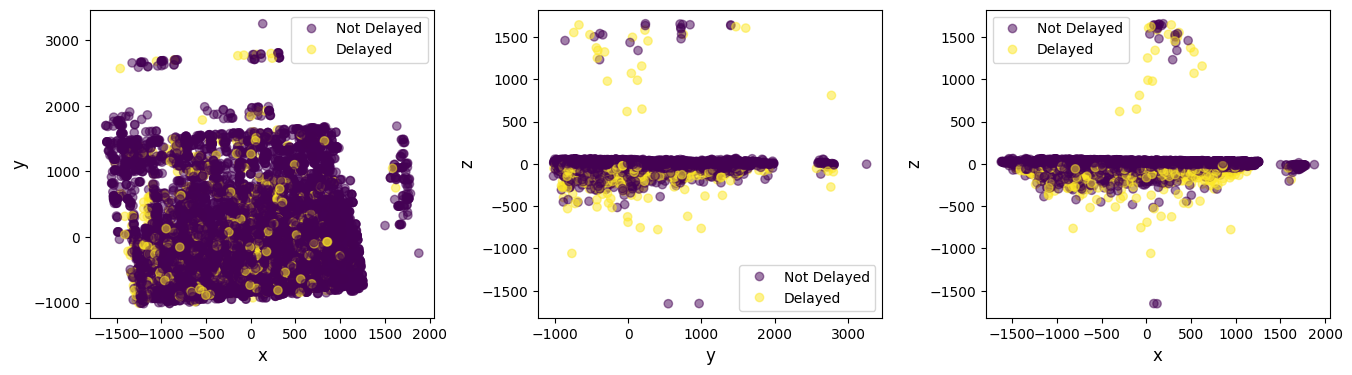

In [22]:
mldatasets.plot_3dim_decomposition(
    dimred_methods["pca"]["lowdim"], y_test_class.values[sample_idx], y_names
)

Визуализация результатов на основе t-SNE

/var/folders/rg/tppcrnhx45335twpt226wpf00000gn/T/ipykernel_43329/2686051228.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(


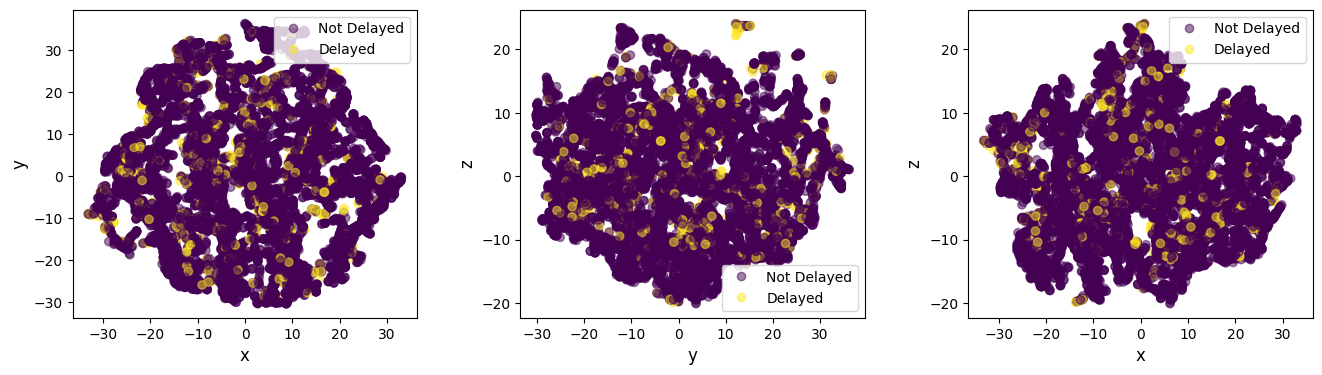

In [23]:
mldatasets.plot_3dim_decomposition(
    dimred_methods["t-sne"]["lowdim"], y_test_class.values[sample_idx], y_names
)

Визуализация результатов на основе VAE

/var/folders/rg/tppcrnhx45335twpt226wpf00000gn/T/ipykernel_43329/435530050.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(


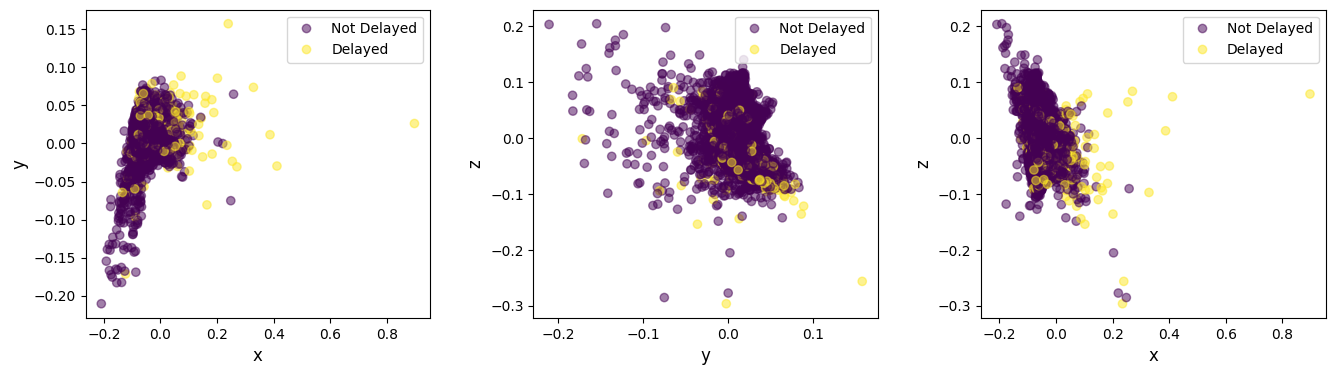

In [24]:
mldatasets.plot_3dim_decomposition(
    dimred_methods["vae"]["lowdim"], y_test_class.values[sample_idx], y_names
)

Подготовка оценок результатов работы классификатора ridge для визуализации

In [ ]:
y_test_class_samp = y_test_class.values[sample_idx]
y_test_pred_samp = class_models["ridge"]["preds"][sample_idx]
error_vector, error_labels = mldatasets.encode_classification_error_vector(
    y_test_class_samp, y_test_pred_samp
)

Визуализация оценок на основе PCA

/var/folders/rg/tppcrnhx45335twpt226wpf00000gn/T/ipykernel_43329/3481318415.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(


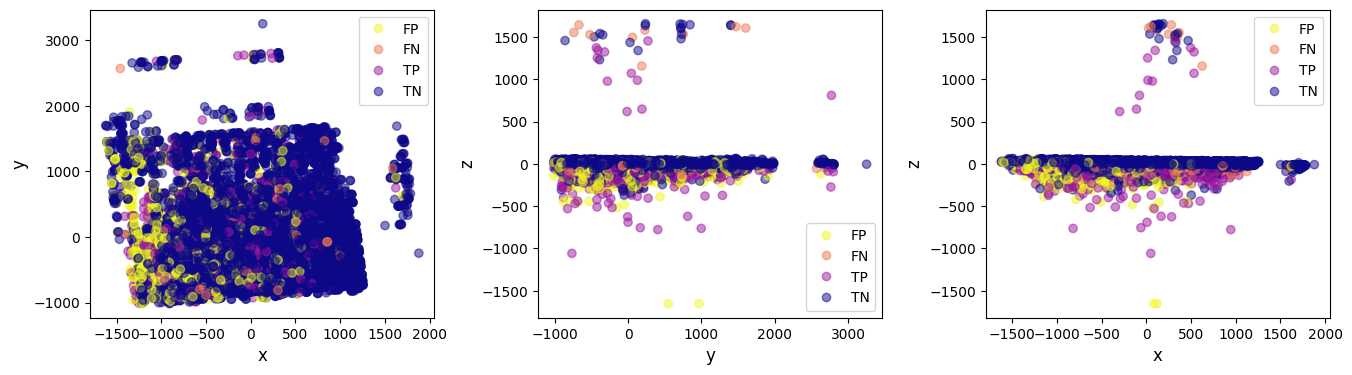

In [26]:
mldatasets.plot_3dim_decomposition(
    dimred_methods["pca"]["lowdim"], error_vector, error_labels
)

Визуализация оценок на основе t-SNE

/var/folders/rg/tppcrnhx45335twpt226wpf00000gn/T/ipykernel_43329/1348333015.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(


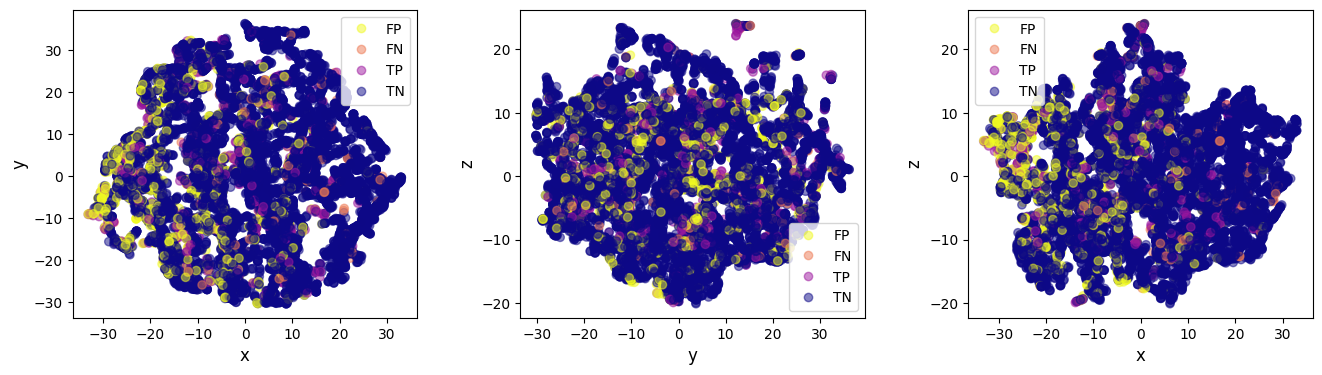

In [27]:
mldatasets.plot_3dim_decomposition(
    dimred_methods["t-sne"]["lowdim"], error_vector, error_labels
)

Визуализация оценок на основе VAE

/var/folders/rg/tppcrnhx45335twpt226wpf00000gn/T/ipykernel_43329/251252098.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(


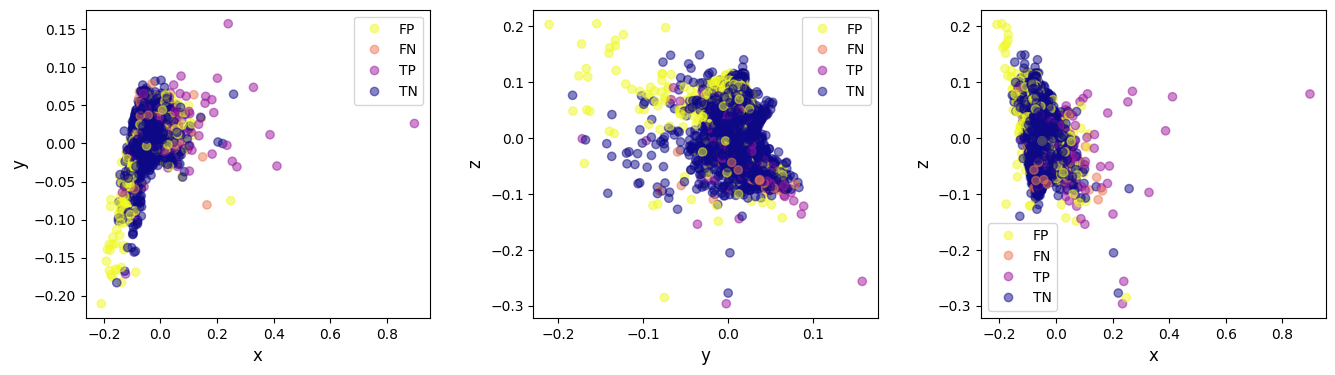

In [28]:
mldatasets.plot_3dim_decomposition(
    dimred_methods["vae"]["lowdim"], error_vector, error_labels
)

Интерпретация результатов для моделей на основе "белого ящика"

Линейная регрессия

In [29]:
coefs_lm = reg_models["linear"]["fitted"].coef_
intercept_lm = reg_models["linear"]["fitted"].intercept_
print("coefficients:\t%s" % coefs_lm)
print("intercept:\t%s" % intercept_lm)
print(
    "y = %0.2f + %0.4fX1 + %0.4fX2 + %0.3fX3 + ..."
    % (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2])
)

coefficients:	[ 4.54984539e-03 -5.25067742e-03  8.94125541e-01 -1.52961053e-02
 -4.69623002e-01  1.25277815e-01 -6.46744472e-04 -1.26240049e-02
  4.50112895e+01  6.76385421e-04 -3.69920254e-04  5.47855860e-04
  3.73866548e-01 -9.06364154e-01 -6.74052666e-01 -9.17411191e-01
 -9.29843952e-01 -3.96621856e-02 -1.79666480e-02 -1.02912927e+00
 -3.94934854e-01]
intercept:	-37.86177932752954
y = -37.86 + 0.0045X1 + -0.0053X2 + 0.894X3 + ...


In [30]:
coef_df = pd.DataFrame({"feature": X_train.columns.values.tolist(), "coef": coefs_lm})
print(coef_df)

                feature       coef
0          CRS_DEP_TIME   0.004550
1              DEP_TIME  -0.005251
2             DEP_DELAY   0.894126
3              DEP_AFPH  -0.015296
4              DEP_RFPH  -0.469623
5              TAXI_OUT   0.125278
6            WHEELS_OFF  -0.000647
7      CRS_ELAPSED_TIME  -0.012624
8      PCT_ELAPSED_TIME  45.011289
9              DISTANCE   0.000676
10         CRS_ARR_TIME  -0.000370
11             ARR_AFPH   0.000548
12             ARR_RFPH   0.373867
13        WEATHER_DELAY  -0.906364
14            NAS_DELAY  -0.674053
15       SECURITY_DELAY  -0.917411
16  LATE_AIRCRAFT_DELAY  -0.929844
17            DEP_MONTH  -0.039662
18              DEP_DOW  -0.017967
19           ORIGIN_HUB  -1.029129
20             DEST_HUB  -0.394935


In [31]:
import statsmodels.api as sm

linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
summary_df = linreg_mdl.summary2().tables[1]
summary_df = (
    summary_df.drop(["const"]).reset_index().rename(columns={"index": "feature"})
)
summary_df["t_abs"] = abs(summary_df["t"])
summary_df.sort_values(by="t_abs", ascending=False).style.background_gradient(
    cmap="plasma_r", low=0, high=0.1, subset=["P>|t|"]
).background_gradient(cmap="plasma_r", low=0, high=0.1, subset=["t_abs"])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.894126,0.000303,2951.055978,0.000000,0.893532,0.894719,2951.055978
16,LATE_AIRCRAFT_DELAY,-0.929844,0.000509,-1827.018082,0.000000,-0.930841,-0.928846,1827.018082
13,WEATHER_DELAY,-0.906364,0.000911,-995.366423,0.000000,-0.908149,-0.904579,995.366423
14,NAS_DELAY,-0.674053,0.000813,-829.128657,0.000000,-0.675646,-0.672459,829.128657
8,PCT_ELAPSED_TIME,45.011289,0.117195,384.072566,0.000000,44.781592,45.240987,384.072566
15,SECURITY_DELAY,-0.917411,0.005465,-167.857085,0.000000,-0.928123,-0.906699,167.857085
5,TAXI_OUT,0.125278,0.001203,104.119579,0.000000,0.122920,0.127636,104.119579
0,CRS_DEP_TIME,0.004550,0.000072,62.871693,0.000000,0.004408,0.004692,62.871693
1,DEP_TIME,-0.005251,0.000092,-57.115895,0.000000,-0.005431,-0.005070,57.115895
3,DEP_AFPH,-0.015296,0.000321,-47.724506,0.000000,-0.015924,-0.014668,47.724506


Гребневая регрессия

In [32]:
coefs_ridge = reg_models["ridge"]["fitted"].coef_
coef_ridge_df = pd.DataFrame(
    {
        "feature": X_train.columns.values.tolist(),
        "coef_linear": coefs_lm,
        "coef_ridge": coefs_ridge,
    }
)
coef_ridge_df.style.background_gradient(cmap="viridis_r", low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,CRS_DEP_TIME,0.004550,0.004002
1,DEP_TIME,-0.005251,-0.005771
2,DEP_DELAY,0.894126,0.894875
3,DEP_AFPH,-0.015296,-0.015324
4,DEP_RFPH,-0.469623,-0.469622
5,TAXI_OUT,0.125278,0.125291
6,WHEELS_OFF,-0.000647,-0.001168
7,CRS_ELAPSED_TIME,-0.012624,-0.012603
8,PCT_ELAPSED_TIME,45.011289,45.010279
9,DISTANCE,0.000676,0.000824


Полиномиальная регрессия

In [33]:
print(
    reg_models["linear_poly"]["fitted"].get_params()["linearregression"].coef_.shape[0]
)
print(
    reg_models["linear_interact"]["fitted"]
    .get_params()["linearregression"]
    .coef_.shape[0]
)

253
232


Логистическая регрессия

In [34]:
coefs_log = class_models["logistic"]["fitted"].coef_
intercept_log = class_models["logistic"]["fitted"].intercept_
print("coefficients:\t%s" % coefs_log)
print("intercept:\t%s" % intercept_log)
stdv = np.std(X_train, 0)
abs(
    coefs_log.reshape(
        21,
    )
    * stdv
).sort_values(ascending=False)

coefficients:	[[-0.00106279 -0.00028647  0.1598025   0.00206963 -0.00211765 -0.00480944
   0.00052281 -0.05132011 -0.00174057  0.00555017 -0.0002319  -0.0072204
  -0.00270335 -0.15045084 -0.11873107 -0.00583663 -0.16364218 -0.01291034
  -0.00523968  0.00047128 -0.00203634]]
intercept:	[-0.00226912]


DEP_DELAY              7.073562
CRS_ELAPSED_TIME       4.073575
LATE_AIRCRAFT_DELAY    4.043871
DISTANCE               3.604432
NAS_DELAY              1.636119
WEATHER_DELAY          1.572172
CRS_DEP_TIME           0.532889
WHEELS_OFF             0.270083
ARR_AFPH               0.255337
DEP_TIME               0.147503
CRS_ARR_TIME           0.122474
DEP_AFPH               0.073379
TAXI_OUT               0.047465
DEP_MONTH              0.044059
DEP_DOW                0.010471
SECURITY_DELAY         0.009567
ARR_RFPH               0.001950
DEP_RFPH               0.001196
DEST_HUB               0.000991
ORIGIN_HUB             0.000229
PCT_ELAPSED_TIME       0.000183
dtype: float64

Дерево решений

In [35]:
text_tree = tree.export_text(
    class_models["decision_tree"]["fitted"],
    feature_names=X_train.columns.values.tolist(),
)
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [36]:
dt_imp_df = pd.DataFrame(
    {
        "feature": X_train.columns.values.tolist(),
        "importance": class_models["decision_tree"]["fitted"].feature_importances_,
    }
).sort_values(by="importance", ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
16,LATE_AIRCRAFT_DELAY,0.199153
8,PCT_ELAPSED_TIME,0.105381
13,WEATHER_DELAY,0.101649
14,NAS_DELAY,0.062732
15,SECURITY_DELAY,0.001998
9,DISTANCE,0.001019
7,CRS_ELAPSED_TIME,0.000281
5,TAXI_OUT,0.000239
6,WHEELS_OFF,0.000035


Дерево решений (RuleFit)

In [37]:
rulefit_df = reg_models["rulefit"]["fitted"].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(
    by="importance", ascending=False
)
rulefit_df

,rule,type,coef,support,importance
39,LATE_AIRCRAFT_DELAY <= 222.5 & DEP_DELAY > 344...,rule,222.036846,0.001684,9.102610
69,LATE_AIRCRAFT_DELAY <= 333.5 & DEP_DELAY > 477.5,rule,172.088101,0.001122,5.761932
16,LATE_AIRCRAFT_DELAY,linear,-0.385614,1.000000,4.518290
2,DEP_DELAY,linear,0.163830,1.000000,4.286205
62,DEP_DELAY <= 1206.0,rule,-275.106546,0.999813,3.762234
...,...,...,...,...,...
18,DEP_DOW,linear,0.009914,1.000000,0.019813
29,DEP_DELAY > 181.5,rule,0.147233,0.008792,0.013744
25,DEP_DELAY <= 880.5,rule,-0.300849,0.999252,0.008226
85,DEP_DELAY <= 48.5 & DEP_DELAY <= 136.5,rule,-0.012917,0.922933,0.003445


k ближайших соседей

In [38]:
print(X_test.loc[721043, :])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [39]:
print(
    class_models["knn"]["fitted"].kneighbors(
        X_test.loc[721043, :].values.reshape(1, 21), 7
    )
)

(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
        243.57211853, 259.61593993, 259.77507391]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))


/Users/user/Projects/python/ai/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [40]:
print(y_train_class.iloc[[105172, 571912, 73409, 89450, 77474, 705972, 706911]])

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64


In [41]:
print(class_models["knn"]["fitted"].effective_metric_)

euclidean


Гауссов наивный Байес

In [42]:
print(class_models["naive_bayes"]["fitted"].class_prior_)

[0.93871674 0.06128326]


In [45]:
print(class_models["naive_bayes"]["fitted"].var_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 2.39015406e-01
  2.34996222e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 1.77750796e-01
  2.50208354e-01]]


In [44]:
print(class_models["naive_bayes"]["fitted"].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 6.06800513e-01
  6.24199571e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 7.69575517e-01
  4.85391724e-01]]
